# Assignment 2

Code submitted for Assignment 2, DA526, 2023, IITG.

Team Members: Vikky Masih, Pallapu Mohan Krishna, Shania H, Rahul Bhardwaj, Prakhar Kumar Sonkar

(c)2023 Vikky Masih, MFS DS&AI, IITG. Free for educational use.

In [1]:
import math
import time
import copy 

import pandas as pd

import torch
from torch import nn

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, Compose, Lambda

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from skimage.feature import hog

import matplotlib.pyplot as plt
import seaborn as sns



C:\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.has_mps else device
print(f"Using {device} device")

if device=="cuda":
    !nvidia-smi

Using cuda device
Tue May  2 11:13:01 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.41                 Driver Version: 531.41       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090       WDDM | 00000000:01:00.0  On |                  Off |
|  0%   37C    P8               14W / 450W|    598MiB / 24564MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+-------

In [3]:
training_data=datasets.FashionMNIST('data',train=True,download=True,transform=ToTensor())
test_data=datasets.FashionMNIST('data',train=False,download=True,transform=ToTensor())
classNames=training_data.classes

In [4]:
training_data.transform=Compose([ToTensor(),\
                                 Lambda(lambda x:(x.to(torch.float32)-127.)/127.)])
test_data.transform=training_data.transform

In [5]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, indices, transform=None, target_transform=None):
        self.data=data
        self.labels=labels
        self.indices=indices
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        outX = self.data[self.indices[idx]].to(torch.float32)
        outY = self.labels[self.indices[idx]]
        if self.transform:
            outX = self.transform(outX)
        if self.target_transform:
            outY = self.target_transform(outY)
        return outX, outY

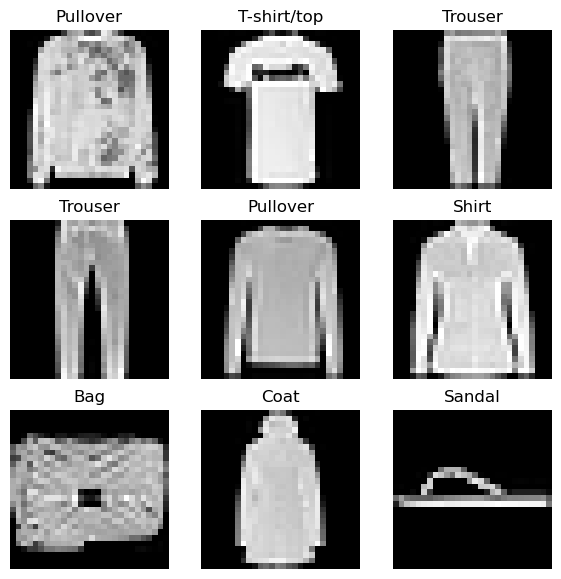

In [6]:
figure = plt.figure(figsize=(7, 7))
size = 3
for i in range(1, size * size + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(size, size, i)
    plt.title(classNames[label])
    plt.axis("off")
    plt.imshow(img.squeeze(),cmap='gray')
plt.show()

In [7]:
maxNeighbors=32

# Helper function for Brute Force KNN
Useful if $N_{training}<<2^{dim}$. Otherwise use kd-tree.

In [8]:
def naive_knn(test_data,training_data,neighbors=32):
    knn=torch.zeros(test_data.shape[0],neighbors,dtype=torch.int)
    dim=[x for x in range(1,len(test_data.shape))]
    for k in range(test_data.shape[0]):
        d=(training_data-test_data[k].unsqueeze(0)).pow(2).sum(dim=dim)
        v,i=d.sort()
        knn[k,:]=i[:neighbors].cpu()
    return(knn)

# Pixel values based kNN Classification

In [9]:
# Finding K-Nearest Neighbors using Brute Force Method
knn=naive_knn(test_data.data.to(float).to(device),\
              training_data.data.to(float).to(device),\
              neighbors=maxNeighbors)

# Finding classes of K-Nearest Neighbors
knn_classes=training_data.targets[knn]

# Calculating accuracy for different k
knn_accuracy=torch.zeros(maxNeighbors)
for k in range(maxNeighbors):
    knn_predict=knn_classes[:,:k+1].mode()[0]
    knn_accuracy[k]=(test_data.targets==knn_predict).sum()/len(test_data)*100

All Pixel based kNN Max Accuracy = 85.77%
All Pixel based kNN best K = 4


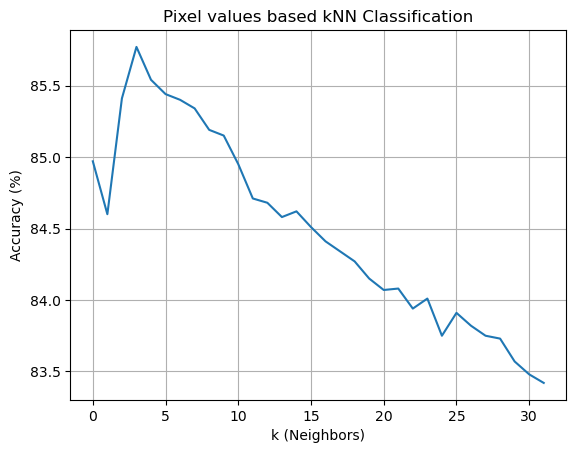

In [10]:
print(f"All Pixel based kNN Max Accuracy = {float(knn_accuracy.max()):.2f}%")
bestK=int(knn_accuracy.argmax()+1)
print(f"All Pixel based kNN best K = {bestK}")
plt.plot(range(maxNeighbors),knn_accuracy)
plt.xlabel("k (Neighbors)")
plt.ylabel("Accuracy (%)")
plt.title("Pixel values based kNN Classification")
plt.grid()
plt.show()

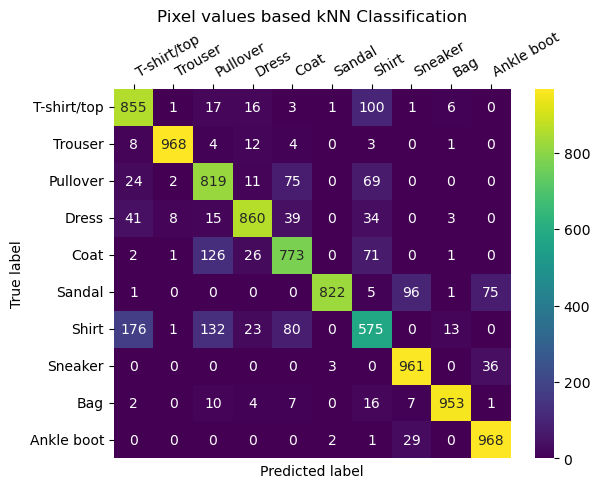

In [11]:
# Confusion Matrix
knn_predict=knn_classes[:,:bestK+1].mode()[0]
CM=confusion_matrix(test_data.targets, knn_predict)

df_cm = pd.DataFrame(CM, index=classNames, columns=classNames).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='viridis')

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=30, ha='left')
heatmap.xaxis.tick_top()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Pixel values based kNN Classification")
plt.show()

# HOG Features based kNN Classification

In [12]:
img=training_data.data[0]
hog_N=len(hog(img))

trainN=len(training_data)
testN=len(test_data)
trainingHOG=torch.zeros(trainN,hog_N)
for k in range(trainN):
    trainingHOG[k,:]=torch.tensor(hog(training_data.data[k]))
testHOG=torch.zeros(testN,hog_N)
for k in range(testN):
    testHOG[k,:]=torch.tensor(hog(test_data.data[k]))
    
trainingHOG=trainingHOG.to(device)
testHOG=testHOG.to(device)

In [13]:
# Finding K-Nearest Neighbors using Brute Force Method
knnHOG=naive_knn(testHOG,trainingHOG,maxNeighbors)

# Finding classes of K-Nearest Neighbors
knnHOG_classes=training_data.targets[knnHOG]

# Calculating accuracy for different k
knnHOG_accuracy=torch.zeros(maxNeighbors)
for k in range(maxNeighbors):
    knnHOG_predict=knnHOG_classes[:,:k+1].mode()[0]
    knnHOG_accuracy[k]=(test_data.targets==knnHOG_predict).sum()/len(test_data)*100

HOG Features based kNN Max Accuracy = 83.67%
HOG Features based kNN best K = 20


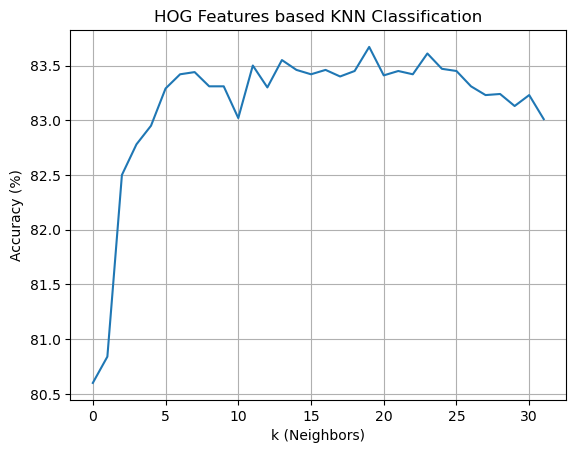

In [14]:
print(f"HOG Features based kNN Max Accuracy = {float(knnHOG_accuracy.max()):.2f}%")
bestK=int(knnHOG_accuracy.argmax()+1)
print(f"HOG Features based kNN best K = {bestK}")
plt.plot(range(maxNeighbors),knnHOG_accuracy)
plt.xlabel("k (Neighbors)")
plt.ylabel("Accuracy (%)")
plt.title("HOG Features based KNN Classification")
plt.grid()
plt.show()

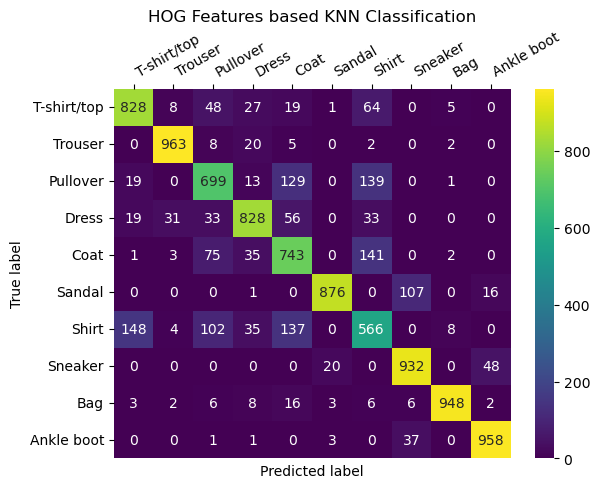

In [15]:
# Confusion Matrix
knnHOG_predict=knnHOG_classes[:,:bestK+1].mode()[0]
CM=confusion_matrix(test_data.targets, knnHOG_predict)

df_cm = pd.DataFrame(CM, index=classNames, columns=classNames).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='viridis')

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=30, ha='left')
heatmap.xaxis.tick_top()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("HOG Features based KNN Classification")
plt.show()

# Denoising Auto Encoder Latent Features based kNN Classification

In [16]:
# Helper function for training loop
def train_model_autoencoder(model, 
                dataTrain, 
                dataValidate, 
                optimizer, 
                scheduler=None,
                criterion=torch.nn.MSELoss(),
                device='cpu', 
                num_epochs=25):
    startTime = time.time()
    
    numTrain = len(dataTrain.dataset)
    numVal = len(dataValidate.dataset)
    if scheduler is not None:
        schedulerNeedsInput=str(type(scheduler)).find("ReduceLROnPlateau")!=-1

    history=[]
    topModelState = copy.deepcopy(model.state_dict())
    topModelLoss = float('inf')
    
    model.to(device)
    for epoch in range(num_epochs):
        print('-' * 80)
        print(f'Epoch {epoch+1}/{num_epochs}')

        tic = time.time()
        model.train()
        trainLoss = 0
        trainTruePositives = 0
        for inputs,targets in dataTrain:
            inputs = inputs.to(device)
            #targets = targets.to(device)
            
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                modelOutputs = model(inputs)
                #predictedClass = torch.max(modelOutputs, 1)[1]
                loss = criterion(modelOutputs, inputs.flatten(1))                
                loss.backward()
                optimizer.step()        
            trainLoss += loss.item() * targets.size(0)
            #trainTruePositives += torch.sum(predictedClass == torch.max(targets,1)[1])        
        toc = time.time()
        trainLoss /= numTrain
        #trainAccuracy = trainTruePositives.double() / numTrain
        trainTime = toc-tic
        print(f'Training   | Loss: {trainLoss:10.4f} | Elapsed: {trainTime:5.0f}s')

        tic = time.time()
        model.eval()
        valLoss = 0
        valTruePositives = 0
        for inputs, targets in dataValidate:
            inputs = inputs.to(device)
            #targets = targets.to(device)
            
            with torch.set_grad_enabled(False):
                modelOutputs = model(inputs)
                #predictedClass = torch.max(modelOutputs, 1)[1]
                loss = criterion(modelOutputs, inputs.flatten(1))               
            valLoss += loss.item() * len(targets)
            #valTruePositives += torch.sum(predictedClass == torch.max(targets,1)[1])  
        toc = time.time()
        
        valLoss /= numVal
        #valAccuracy = valTruePositives.double() / numVal
        valTime = toc-tic
        print(f'Validation | Loss: {valLoss:10.4f} | Elapsed: {valTime:5.0f}s')
        
        if scheduler is not None:
            if schedulerNeedsInput:
                scheduler.step(valLoss)
            else:
                scheduler.step()

        if valLoss < topModelLoss:
            topModelLoss = valLoss
            topModelState = copy.deepcopy(model.state_dict())
        history.append([trainLoss,trainTime,valLoss,valTime])
    time_elapsed = time.time() - startTime
    print("="*80)
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best model loss: {topModelLoss : .2f}')

    # load best model weights
    model.load_state_dict(topModelState)
    return model, torch.tensor(history)

In [17]:
# Dataset split based on stratified K-fold strategy
skf = StratifiedKFold(n_splits=5)
(trainIndices,valIndices)=next(skf.split(range(0,len(training_data)),training_data.targets))
trainDataset=CustomDataset(training_data.data,\
                           training_data.targets,\
                           trainIndices)
valDataset=CustomDataset(training_data.data,\
                         training_data.targets,\
                         valIndices)

In [18]:
# Dataloaders with batch size = 32
trainDataloader=DataLoader(trainDataset, batch_size=32, shuffle=True)
valDataloader=DataLoader(valDataset, batch_size=32, shuffle=True)

In [19]:
# Denoising Auto Encoder Neural Network Class
class Network_AutoEncoder(nn.Module):
    def __init__(self,inSize,hiddenSizes,device='cpu'):
        super(Network_AutoEncoder, self).__init__()
        self.inSize = inSize
        self.hiddenSizes = hiddenSizes
        self.device = device
        
        # Encode
        self.encoder = nn.Sequential()
        self.decoder = nn.Sequential()
        s=[inSize]+hiddenSizes
        for k in range(len(hiddenSizes)):
            self.encoder.append(nn.Linear(s[k],s[k+1]))
            self.encoder.append(nn.LeakyReLU())
            #self.encoder.append(nn.BatchNorm1d(s[k+1]))
            self.decoder.append(nn.Linear(s[-k-1],s[-k-2]))
            self.decoder.append(nn.LeakyReLU())
            #self.decoder.append(nn.BatchNorm1d(s[-k-2]))

    def forward(self, x):
        #print(x.shape)
        x=x.flatten(1)
        x=x+torch.randn_like(x)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [20]:
# Model instance with latent dimension of 100
model=Network_AutoEncoder(inSize=784,\
                   hiddenSizes=[100],\
                   device=device)
print(model)

Network_AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=784, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
)


In [21]:
# Optimize model by changing parameters of the entire model. L2 Regularized
optimizer = torch.optim.Adam(model.parameters(),weight_decay=0.1)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',verbose=True)

# Cross entropy loss for classification
criterion = torch.nn.MSELoss()

# Max number of epochs
num_epochs = 75

In [22]:
# Training
trainedModel, trainHistory = train_model_autoencoder(model, 
                                                        dataTrain=trainDataloader, 
                                                        dataValidate=valDataloader,
                                                        optimizer=optimizer,
                                                        scheduler=scheduler,
                                                        criterion=criterion,
                                                        device=device,
                                                        num_epochs=num_epochs
                                                       )

--------------------------------------------------------------------------------
Epoch 1/75
Training   | Loss:  1076.2092 | Elapsed:     2s
Validation | Loss:   634.9917 | Elapsed:     0s
--------------------------------------------------------------------------------
Epoch 2/75
Training   | Loss:   561.1930 | Elapsed:     2s
Validation | Loss:   515.3432 | Elapsed:     0s
--------------------------------------------------------------------------------
Epoch 3/75
Training   | Loss:   493.8789 | Elapsed:     2s
Validation | Loss:   483.5149 | Elapsed:     0s
--------------------------------------------------------------------------------
Epoch 4/75
Training   | Loss:   470.1469 | Elapsed:     2s
Validation | Loss:   463.6193 | Elapsed:     0s
--------------------------------------------------------------------------------
Epoch 5/75
Training   | Loss:   458.2008 | Elapsed:     2s
Validation | Loss:   479.6336 | Elapsed:     0s
------------------------------------------------------------

Training   | Loss:   386.3033 | Elapsed:     2s
Validation | Loss:   395.3831 | Elapsed:     0s
--------------------------------------------------------------------------------
Epoch 45/75
Training   | Loss:   386.3256 | Elapsed:     2s
Validation | Loss:   396.2723 | Elapsed:     0s
--------------------------------------------------------------------------------
Epoch 46/75
Training   | Loss:   386.2756 | Elapsed:     2s
Validation | Loss:   395.5240 | Elapsed:     0s
--------------------------------------------------------------------------------
Epoch 47/75
Training   | Loss:   386.1977 | Elapsed:     2s
Validation | Loss:   395.7764 | Elapsed:     0s
--------------------------------------------------------------------------------
Epoch 48/75
Training   | Loss:   386.1849 | Elapsed:     2s
Validation | Loss:   395.4182 | Elapsed:     0s
--------------------------------------------------------------------------------
Epoch 49/75
Training   | Loss:   386.1211 | Elapsed:     2s
Validat

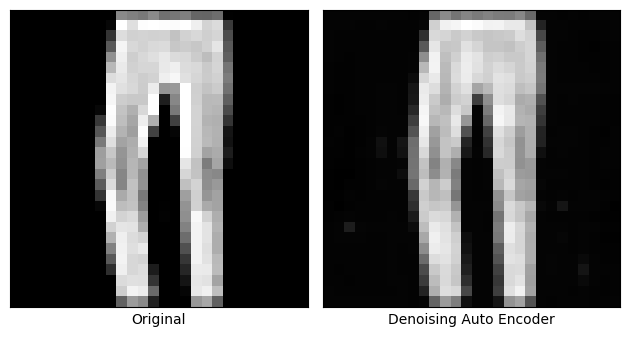

In [23]:
# Verifying Auto Encoder capability

for k in trainDataloader:
    break

plt.subplot(121)
plt.imshow(k[0][15].squeeze(),cmap='gray')
plt.xticks([])
plt.yticks([])
plt.xlabel("Original")
plt.subplot(122)
gen=trainedModel(k[0].flatten(1).to(device))[15].cpu().detach().reshape(28,28)
plt.imshow(gen,cmap='gray')
plt.xticks([])
plt.yticks([])
plt.xlabel("Denoising Auto Encoder")
plt.tight_layout()
plt.show()

In [24]:
# Encoding Training and Test samples
trainSamples=((training_data.data-127.)/127.).flatten(1).to(device)
testSamples=((test_data.data-127.)/127.).flatten(1).to(device)
with torch.set_grad_enabled(False):
    trainSamplesEnc=trainedModel.encoder(trainSamples)
    testSamplesEnc=trainedModel.encoder(testSamples)

In [25]:
# Finding K-Nearest Neighbors using Brute Force Method
knnAE=naive_knn(testSamplesEnc,trainSamplesEnc,maxNeighbors)

# Finding classes of K-Nearest Neighbors
knnAE_classes=training_data.targets[knnAE]

# Calculating accuracy for different k
knnAE_accuracy=torch.zeros(maxNeighbors)
for k in range(maxNeighbors):
    knnAE_predict=knnAE_classes[:,:k+1].mode()[0]
    knnAE_accuracy[k]=(test_data.targets==knnAE_predict).sum()/len(test_data)*100

Denoising Auto Encoder Latent Features based kNN Max Accuracy = 84.36%
Denoising Auto Encoder Latent Features based kNN best K = 6


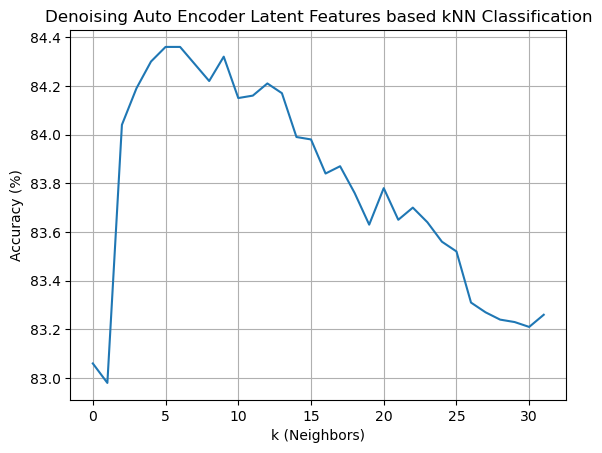

In [26]:
print(f"Denoising Auto Encoder Latent Features based kNN Max Accuracy = {float(knnAE_accuracy.max()):.2f}%")
bestK=int(knnAE_accuracy.argmax()+1)
print(f"Denoising Auto Encoder Latent Features based kNN best K = {bestK}")
plt.plot(range(maxNeighbors),knnAE_accuracy)
plt.xlabel("k (Neighbors)")
plt.ylabel("Accuracy (%)")
plt.title("Denoising Auto Encoder Latent Features based kNN Classification")
plt.grid()
plt.show()

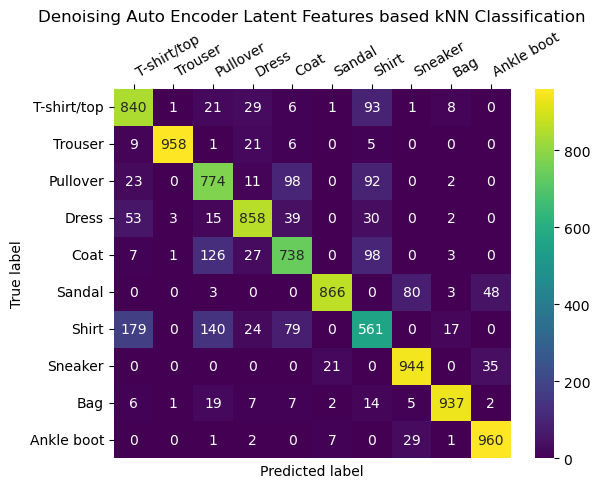

In [27]:
# Confusion Matrix
knnAE_predict=knnAE_classes[:,:bestK+1].mode()[0]
CM=confusion_matrix(test_data.targets, knnAE_predict)

df_cm = pd.DataFrame(CM, index=classNames, columns=classNames).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='viridis')

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=30, ha='left')
heatmap.xaxis.tick_top()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Denoising Auto Encoder Latent Features based kNN Classification")
plt.show()